In [38]:
#reference: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# local variables
sample_data_path = r'C:\Users\steve\Documents\256\Data\sample_data/'

# user data
user = pd.read_csv(sample_data_path + 'users_sample.csv')
# jobs data
jobs = pd.read_csv(sample_data_path + 'jobs_sample_cleared.csv')
# user history data 
user_history = pd.read_csv(sample_data_path + 'user_history_sample.csv')
# apply history data 
app = pd.read_csv(sample_data_path + 'apps_sample.csv')

## Clean up NA value

In [39]:
jobs.isnull().sum()

Unnamed: 0        0
JobID             0
Title             0
Description       1
Requirements    201
State             0
City              0
dtype: int64

In [40]:
jobs.Description = jobs.Description.fillna("")

In [41]:
jobs.isnull().sum()

Unnamed: 0        0
JobID             0
Title             0
Description       0
Requirements    201
State             0
City              0
dtype: int64

### Build TFT Doc vector

In [42]:
#Combine the column u need (adding city and state increase the word size to 180,000 )
documents = []
for i in range (len(jobs)):
    text = "{} {} {} {}".format(jobs.loc[i, 'Title'],
                                   jobs.loc[i, 'Description'],
                                   jobs.loc[i, 'State'],
                                   jobs.loc[i, 'City'])
    documents.append(text)

## TFIDF Initialize

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
 
# just send in all your docs here
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(documents)
tfidf_vectorizer_vectors

<3915x24563 sparse matrix of type '<class 'numpy.float64'>'
	with 377066 stored elements in Compressed Sparse Row format>

In [44]:
# place tf-idf values in a pandas data frame
tfdf_2 = pd.DataFrame(tfidf_vectorizer_vectors[0].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
sorted_tfdf_2 = tfdf_2.sort_values(by=["tfidf"],ascending=False)
valid_tfdf_2 = sorted_tfdf_2[sorted_tfdf_2['tfidf'] > 0]
dictionary = valid_tfdf_2.T.to_dict('list')

## get All valid TFIDF Word from the entire document

In [45]:
# initialize empty set
tmp_list = [];
All_KeyWords = set(tmp_list)

#initialize a list of each job id's dictionary
job_vector_list = []

#for test purpose define finite job example
total_jobs = len(jobs)

for i in range(total_jobs):
    vector = tfidf_vectorizer_vectors[i]
    tfdf_2 = pd.DataFrame(vector.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
    sorted_tfdf_2 = tfdf_2.sort_values(by=["tfidf"],ascending=False)
    valid_tfdf_2 = sorted_tfdf_2[sorted_tfdf_2['tfidf'] > 0]
    
    #convert pd to dictionary and store in list
    dictionary = valid_tfdf_2.T.to_dict('list')
    job_vector_list.append(dictionary)
    
    #convert pd to set
    indexNamesArr = valid_tfdf_2.index.values
    All_KeyWords = All_KeyWords | set(indexNamesArr)


In [46]:
print("TFIDF dimension ", len(All_KeyWords))
print("total number of jobs ", len(job_vector_list))

TFIDF dimension  24563
total number of jobs  3915






## Similarity : Scalar Product
### x1 = first recruiter, x2 = second recruiter

In [47]:
def sim(x1, x2):
    list2=[] #debug purpose
    total_sum=0
    for key in job_vector_list[x1]:
        if(key in job_vector_list[x2]):
            first_tfidf = job_vector_list[x1][key][0]
            second_tfidf = job_vector_list[x2][key][0]
            list2.append(key) #debug purpose
            total_sum = total_sum + first_tfidf * second_tfidf
    return total_sum
sim(0, 1)

0.1019244238346225

## Drop extra column and constrain job

In [48]:
#Drop extra column and constrain job
sample_app_undrop = app[app['JobID']<=  jobs.iloc[total_jobs-1][1] ]
sample_app = sample_app_undrop.drop(['Split','Unnamed: 0', 'WindowID', 'ApplicationDate'], axis=1)
print(len(sample_app))
print(len(sample_app.JobID.unique()))

4286
3916


### Split Train and Test Data set for Sample_app

In [49]:
sample_app_copy = sample_app.copy()
sample_app_copy = sample_app_copy.sort_values(["JobID"], ascending = (True))
train_sample_app = sample_app_copy[:int((len(sample_app_copy)+1)*.80)] 
test_sample_app = sample_app_copy[int(len(sample_app_copy)*.80+1):] 
print(len(train_sample_app))
print(len(test_sample_app))

3429
857


### Build Dictionary that map jobID to jobIndex (both)

In [50]:
JobID_to_Index = {}
Index_to_JobID = {}
for index in range(len(jobs)):
    if(jobs.iloc[index][1] == 481595):
        print("find")
    JobID_to_Index[jobs.iloc[index][1]] = index
    Index_to_JobID[index] = jobs.iloc[index][1]

### Build Dictionary that map userID to userIndex (both)

In [51]:
#Pre shape user ID to ID
UserID_to_Index = {}
Index_to_UserID = {}
for index in range(len(user)):
    UserID_to_Index[user.iloc[index][1]] = index
    Index_to_UserID[index] = user.iloc[index][1]

### Build M  

In [52]:
##### Adjacent list is used becuase matrix is sparsed avoid wasting space
train_job_adj_list={}   #jobID -> userID
train_user_adj_list={}  #userID -> jobID
for i in range (len(train_sample_app)):
    try:
        train_job_adj_list[train_sample_app.iloc[i][1]].add(train_sample_app.iloc[i][0])
        train_user_adj_list[train_sample_app.iloc[i][0]].add(train_sample_app.iloc[i][1])
    except KeyError:
        train_job_adj_list[train_sample_app.iloc[i][1]] = {train_sample_app.iloc[i][0]}
        train_user_adj_list[train_sample_app.iloc[i][0]] = {train_sample_app.iloc[i][1]}
print(len(train_job_adj_list))
print(len(train_user_adj_list))

3132
746


In [53]:
##### Adjacent list is used becuase matrix is sparsed avoid wasting space
test_job_adj_list={}   #jobID -> userID
test_user_adj_list={}  #userID -> jobID
for i in range (len(test_sample_app)):
    try:
        test_job_adj_list[test_sample_app.iloc[i][1]].add(test_sample_app.iloc[i][0])
        test_user_adj_list[test_sample_app.iloc[i][0]].add(test_sample_app.iloc[i][1])
    except KeyError:
        test_job_adj_list[test_sample_app.iloc[i][1]] = {test_sample_app.iloc[i][0]}
        test_user_adj_list[test_sample_app.iloc[i][0]] = {test_sample_app.iloc[i][1]}
print(len(test_job_adj_list))
print(len(test_user_adj_list))

784
376


### Get Final Matrix M 
#### x=jobID, y=userID

In [54]:
Sim_Matrix=np.zeros(shape=(total_jobs, len(user)))

job_index = 0
for job_index in range(total_jobs):
    for user_index in range(len(user)):
        sigma_sum=0
        user_apply_job = False
        user_ID= Index_to_UserID[user_index]
        if(user_ID in train_user_adj_list):
            for job_ID in train_user_adj_list[user_ID]:
                if(job_ID == 481595):
                    continue
                if(JobID_to_Index[job_ID]==job_index):
                    user_apply_job = True
                    break
                sigma_sum = sigma_sum + sim(job_index, JobID_to_Index[job_ID]) * 1
        if(user_apply_job):
             Sim_Matrix[job_index][user_index]= 1
        else:
            Sim_Matrix[job_index][user_index]= sigma_sum

### Experiment on Cutoff

### Test Recall = True Positive / (True Positive + False Negative)

In [55]:
recallList =[]
cutOffList=[]
for x in np.arange(0, 1.02, 0.02):
    cutOffList.append(x)

for cutOff in cutOffList:
    count=0;
    true_positive=0
    for jobID in test_job_adj_list:
        job_index = JobID_to_Index[jobID]
        for userID in test_job_adj_list[jobID]:
            user_index = UserID_to_Index[userID]
            if Sim_Matrix[job_index][user_index] >= cutOff:
                true_positive = true_positive + 1
            count = count + 1
    accuracy = round(true_positive/count * 100,2)
    recallList.append(accuracy)
print(count)

830


Text(0, 0.5, 'Recall')

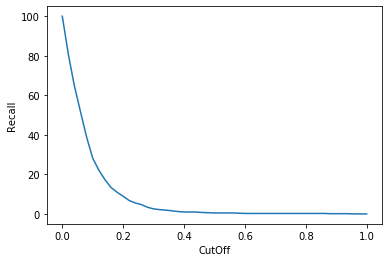

In [56]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(cutOffList, recallList)  # Plot some data on the axes.
ax.set_xlabel('CutOff')
ax.set_ylabel('Recall')

In [57]:
##find smallest Index in test_job_adj_list
minJobID = 10000000
minUserID = 10000000

#Build original test Matrix to avoid duplicate finding process
test_Matrix_Original=np.zeros(shape=(total_jobs, len(user)))
for jobID in test_job_adj_list:
    minJobID = min(minJobID, jobID)  ##calculate min JobID at the same time
    jobIndex = JobID_to_Index[jobID]
    for userID in test_job_adj_list[jobID]:
        minUserID = min(minUserID, userID)  #calculate min userID at the same time
        userIndex = UserID_to_Index[userID]
        test_Matrix_Original[jobIndex][userIndex] = 1

startJobIndex = JobID_to_Index[minJobID]
startUserIndex = UserID_to_Index[minUserID]

print("minimum JobIndex: ", startJobIndex)
print("minimum userIndex: ", startUserIndex)

minimum JobIndex:  3131
minimum userIndex:  1


In [58]:
precisionList = []
for cutOff in cutOffList:
    truePositive=0
    FalsePositive=0
    for i in range (startJobIndex, total_jobs):
        for j in range (startUserIndex, len(user)):
            if Sim_Matrix[i][j] >= cutOff:
                if test_Matrix_Original[i][j] == 1:
                    truePositive = truePositive + 1
                else:
                    FalsePositive = FalsePositive + 1
    if(truePositive + FalsePositive)==0:
        precision = 0
    else:
        precision = round(truePositive/(truePositive + FalsePositive) * 100,2)
    precisionList.append(precision)

print(precisionList)

[0.11, 0.2, 0.31, 0.5, 0.71, 0.92, 1.21, 1.5, 1.74, 2.06, 2.38, 2.51, 2.73, 3.14, 3.05, 2.99, 3.54, 4.22, 4.21, 4.46, 4.94, 5.88, 7.02, 6.19, 6.41, 5.8, 6.35, 6.67, 6.78, 5.56, 3.77, 4.0, 4.35, 4.44, 4.55, 4.65, 4.65, 4.76, 4.76, 5.13, 5.26, 5.41, 5.41, 5.56, 3.03, 3.03, 3.12, 3.33, 0.0, 0.0, 0]


Text(0, 0.5, 'precision')

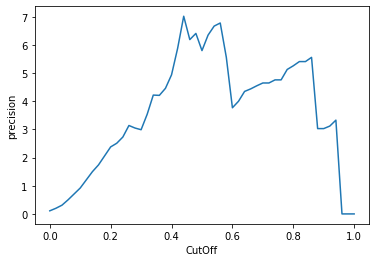

In [59]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(cutOffList, precisionList)  # Plot some data on the axes.
ax.set_xlabel('CutOff')
ax.set_ylabel('precision')

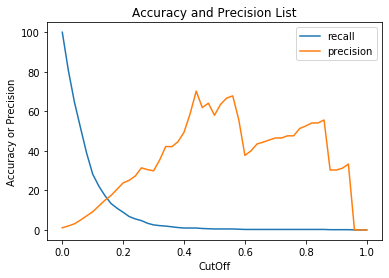

In [60]:
precisionList2 = map(lambda x: x*10, precisionList)
precisionList3 = list(precisionList2)# plotting the line 1 points 
plt.plot(cutOffList, recallList, label = "recall")
plt.plot(cutOffList, precisionList3, label = "precision")
plt.xlabel('CutOff')
plt.ylabel('Accuracy or Precision')
plt.title('Accuracy and Precision List')
plt.legend()
plt.show()